# Rank Histogram

A rank histogram is a graphical tool for evaluating the reliability of ensemble forecasts,
by plotting the relative frequency of an observation's rank against the sorted values of an ensemble forecast.
If an ensemble of forecasts is probabilistically calibrated, then the obseravations should
be statistically indistinguishable from random draws from among the ensemble members, and
consequently the rank histogram should be flat.

The rank histogram is very closely related to the probabiliistic integral transform (PIT) and
PIT histograms. The `scores.probability.Pit` implementation of PIT in `scores` has several
features in addition to histograms, but with the possible downside that an ensemble of forecasts is treated as
an empirical cumulative distribution function.



## Some characteristic shapes of rank histograms

In the first part of this tutorial, we look at some classic types of probabilistic (mis)-calibration
of ensemble forecasts and their characteristic rank histograms.

We consider a process $Y_t$, where $t=0, 1, \ldots, m$, which is generated by the standard normal distribution
$N(0,1)$ as follows:
$$ Y_t \sim N(\mu_t, 1), \qquad\text{where } \mu_t\sim N(\mu_t, 1).$$

We consider six different forecasters who issue ensemble forecasts with 10 ensemble members:

1. **Calibrated (ideal) forecaster**: ensemble members are sampled from $N(\mu_t, 1)$.
2. **Over-prediction forecaster**: ensemble members are sampled from $N(\mu_t + 0.25, 1)$. That is, forecast distribution is higher than the true distribution. than 
3. **Under-prediction forecaster**: ensemble members are sampled from $N(\mu_t - 0.25, 1)$. That is, forecast distribution is lower than the true distribution. 
4. **Over-dispersed forecaster**: ensemble members are sampled from $N(\mu_t, (1.2)^2)$. That is, forecast distribution is wider than the true distribution. 
5. **Under-dispersed forecaster**: ensemble members are sampled from $N(\mu_t, (1/1.2)^2)$. That is, forecast distribution is narrower than the true distribution. 
6. **Calibrated (marginal) forecaster**: ensemble members are sampled from $N(0, 2)$. That is, this forecaster forecasts the ideal distribution given that they have no knowledge of $\mu_t$. This is equivalent to issuing a forecast based on climatology for a meteorological variable. Forecasts are reliable over the long-run but not accurate.

We'll generate observations and corresponding forecasts and plot their rank histograms.

In [ ]:
import numpy as np
import xarray as xr
from scipy.stats import norm
import matplotlib.pyplot as plt
from scores.probability import rank_histogram


n_time = 100000  # total time steps
n_member = 10  # ensemble size

mu = norm.rvs(loc = 0, scale = 1, size=n_time)  # mu_t

# broadcast mu_t against ensemble size to create ensemble forecasts
mu_broadcast = np.broadcast_to(mu, (n_member, n_time))

# generate the observations
obs = xr.DataArray(
    data=norm.rvs(loc = mu, scale = 1, size=n_time),
    dims=['case'],
    coords={'case': range(n_time)},
    name='obs',
)

# generate the forecasts
fcstA = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1, size=(n_member,n_time)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_time)},
    name='calibarated (ideal)',
)
fcstB = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast + 0.25, scale = 1, size=(n_member,n_time)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_time)},
    name='over-prediction',
)
fcstC = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast - 0.25, scale = 1, size=(n_member,n_time)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_time)},
    name='under-prediction',
)
fcstD = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1.2, size=(n_member,n_time)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_time)},
    name='over-dispersed',
)
fcstE = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1 / 1.2, size=(n_member,n_time)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_time)},
    name='under-dispersed',
)
fcstF = xr.DataArray(
    data=norm.rvs(loc = 0, scale = np.sqrt(2), size=(n_member,n_time)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_time)},
    name='calibarated (marginal)',
)
fcst = xr.merge([fcstA, fcstB, fcstC, fcstD, fcstE, fcstF])

# generate values for the rank histogram
rank_hist = rank_histogram(fcst, obs, "ens_member")
rank_hist

/home/rtaggar/scores/src/scores/probability/rank_hist_impl.py:149: UserWarning: Encountered a NaN in `fcst`. Any forecast case with NaN for one ensemble member will be treated as NaN for all ensemble members.
  warnings.warn(


<xarray.Dataset> Size: 616B
Dimensions:                 (rank: 11)
Coordinates:
  * rank                    (rank) int64 88B 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    calibarated (ideal)     (rank) float64 88B 0.09092 0.09052 ... 0.09188
    over-prediction         (rank) float64 88B 0.1313 0.1153 ... 0.06789 0.0599
    under-prediction        (rank) float64 88B 0.05987 0.06649 ... 0.1149 0.1329
    over-dispersed          (rank) float64 88B 0.06224 0.08272 ... 0.06265
    under-dispersed         (rank) float64 88B 0.1239 0.09293 ... 0.09516 0.1234
    calibarated (marginal)  (rank) float64 88B 0.09037 0.09116 ... 0.09144

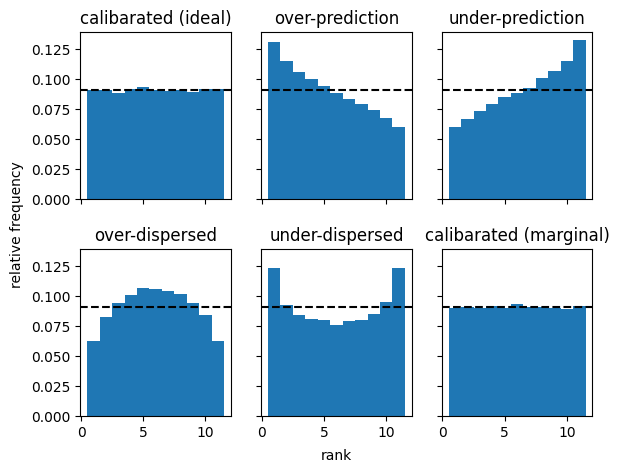

In [36]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)

for fcst_label, i in zip(list(rank_hist.data_vars), range(6)):
    row, col = int(i / 3), i % 3
    axes[row, col].bar(rank_hist['rank'].values, rank_hist[fcst_label].values, width=1)
    axes[row, col].axhline(y=1/(n_member+1), color='k', linestyle='--')
    axes[row, col].set_title(fcst_label)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.3)
fig.text(0.5, 0.01, 'rank', ha='center')
fig.text(-0.01, 0.5, 'relative frequency', va='center', rotation='vertical')

fig.show()

To show that this implementation also handles the case where the observation matches the
value of multiple ensemble members, we consider the above system with negative values clipped to 0.

This kind of situation can occur when forecasting precipitation: multiple ensemble members and the observation may both
have the value 0 (i.e., no rainfall).

/home/rtaggar/scores/src/scores/probability/rank_hist_impl.py:149: UserWarning: Encountered a NaN in `fcst`. Any forecast case with NaN for one ensemble member will be treated as NaN for all ensemble members.
  warnings.warn(


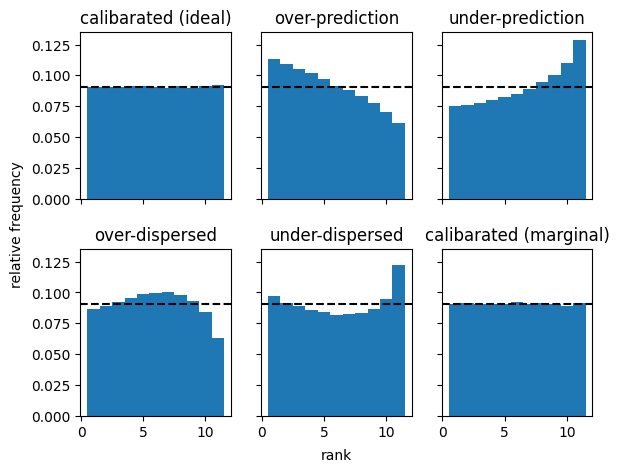

In [37]:
fcst_clipped = fcst.clip(min=0)
obs_clipped = obs.clip(min = 0)
rank_hist_clipped = rank_histogram(fcst_clipped, obs_clipped, "ens_member")

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)

for fcst_label, i in zip(list(rank_hist.data_vars), range(6)):
    row, col = int(i / 3), i % 3
    axes[row, col].bar(rank_hist_clipped['rank'].values, rank_hist_clipped[fcst_label].values, width=1)
    axes[row, col].axhline(y=1/(n_member+1), color='k', linestyle='--')
    axes[row, col].set_title(fcst_label)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.3)
fig.text(0.5, 0.01, 'rank', ha='center')
fig.text(-0.01, 0.5, 'relative frequency', va='center', rotation='vertical')

fig.show()